In [ ]:
import rarfile
import numpy as np
inf=float("inf")

import random
from tqdm import tqdm

import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import umap
import pickle

import os
import stablerank.srank as sr

from dtw import *

import fMRIanalysis.data as data
import fMRIanalysis.plotting as plotting

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# dtw

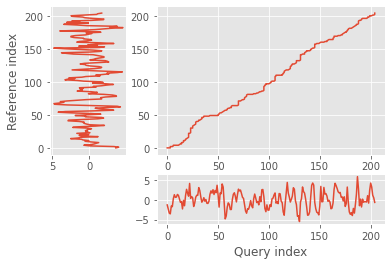

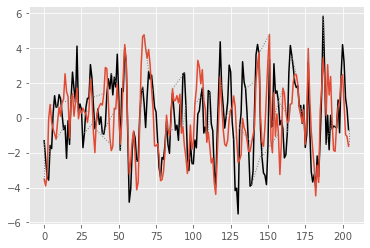

<AxesSubplot:>

In [2]:
fmri = data.TimeSeries().data_mat
timeseries0 = fmri[:,0]
timeseries1 = fmri[:,1]
alignment = dtw(timeseries0, timeseries1, keep_internals=True)

alignment.plot(type="threeway")
alignment.plot(type="twoway")

# Compute dtw matrices

In [123]:
#range_of_subjects = [CTR_start + i for i in range(5)] + [PD_CN_start + i for i in range(5)] + [PD_MCI_start + i for i in range(5)]
#to_remove = [CTR_start + i for i in range(5)] + [PD_CN_start + i for i in range(5)] + [PD_MCI_start + i for i in range(5)]
range_of_subjects = [i for i in range(1, 107)]
#for element in to_remove:
#    range_of_subjects.remove(element)
    
nr_of_areas = 200
for subject in tqdm(range_of_subjects):
    fmri = data.TimeSeries(subject = subject).data_mat
    dist_mat = np.zeros((200, 200))
    for i in range(nr_of_areas):
        for j in range(nr_of_areas):
            timeseries1 = fmri[:,i]
            timeseries2 = fmri[:,j]
            alignment = dtw(timeseries1, timeseries2, distance_only = True)
            dist_mat[i,j] = alignment.distance #/len(alignment.index1)
            
    for i in range(nr_of_areas):
        dist_mat[i, i] = np.nan
    max_val = np.nanmax(dist_mat)
    min_val = np.nanmin(dist_mat)
    dist_mat = (dist_mat - min_val) / (max_val - min_val)
    for i in range(nr_of_areas):
        dist_mat[i, i] = 0
        
    base_path = os.getcwd()
    dist_df = pd.DataFrame(dist_mat)
    dist_df.to_csv(base_path+'\data\Matrices_Naomi\dtw\dtw_Subject'+str(subject)+'.csv', header=None, index=None)

100%|████████████████████████████████████████████████████████████████████████████████| 91/91 [1:40:17<00:00, 66.12s/it]


In [28]:
#method = "dtw"
#for subject in tqdm(range_of_subjects):
#    filename = os.getcwd()+"\\data\\Matrices_Naomi\\"+method+"\\"+method+"_Subject"+str(subject)+".csv"
#    dist_df = pd.read_csv(filename, header=None)
#    dist_df = dist_df.drop(0).drop(0, axis = 1)
#    dist_df.to_csv(os.getcwd()+'\data\Matrices_Naomi\dtw2\dtw_Subject'+str(subject)+'.csv', header=None, index=None)

100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [00:09<00:00, 10.82it/s]


# Compute and plot stable ranks for various similarity measures

  0%|                                                                                          | 0/106 [00:00<?, ?it/s]


TypeError: __init__() got an unexpected keyword argument 'submethod'

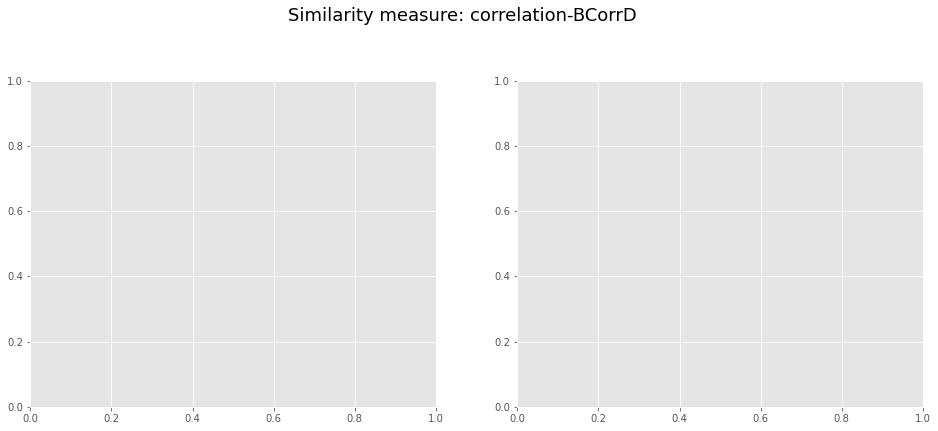

In [2]:
## CTR_start = 1
PD_CN_start = 16
PD_MCI_start = 88

methods = ["correlation", "transferEntropy", "dtw"]
#range_of_subjects = [CTR_start + i for i in range(5)] + [PD_CN_start + i for i in range(5)] + [PD_MCI_start + i for i in range(5)]
range_of_subjects = range(1, 107)

for method in methods:
    if method == "correlation":
        submethods = ["BCorrD", "BCorrU"] #, "PCorrD", "PCorrU"]
    elif method == "transferEntropy":
        submethods = ["BTED", "BTEU"] #, "PTED", "PTEU"]
    elif method == "dtw":
        submethods = [None]
    for submethod in submethods:
        plotting.compute_and_plot_sr(range_of_subjects=range_of_subjects, 
                                     method=method, 
                                     submethod=submethod,
                                     symmetrization=None,
                                     neg_vals_method="clip_zero",
                                     cor_to_dist_func="linear",
                                     max_hom=1,
                                     number_instances=20,
                                     sample_size=50,
                                     probabilities=200)

# Compute delayedPearson correlation (test)

In [5]:
subject = 1
fmri = data.TimeSeries(subject=subject)
test_mat = data.delayed_Pearson_correlation(fmri=fmri, delay=2)

In [6]:
class DataFile:
    def __init__(self, delay=1, subject=1):
        self.delay = delay
        self.subject = subject
        self.size = 200
        
        self.filename = "data/C200_delay"+str(delay)+"_asym_matrices/C200_delay"+str(delay)+"_Subject_"+str(subject)
        self.data_df = pd.read_csv(self.filename, header=None)
        self.data_mat = self.data_df.to_numpy()
        
ref_mat = DataFile(delay=2).data_mat

C:\Users\naomi\AppData\Local\Miniconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  after removing the cwd from sys.path.


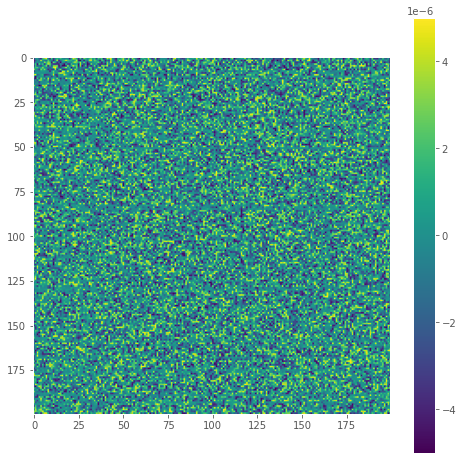

In [7]:
plt.figure(figsize=(8,8))
plt.grid(False)
plt.imshow(ref_mat-test_mat)
plt.colorbar()

In [ ]:
subject = 1
method = "filtered_delayedPearson"
submethod = "FDP_delay1"
symmetrization = "antisymmetric_part"

filename = os.getcwd()+"\\data\\Matrices_Naomi\\"+method+"\\"+submethod+"\\"+submethod+"_Subject"+str(subject)+".csv"
dist_df = pd.read_csv(filename, header=None).clip(lower=0)
dist_mat = dist_df.to_numpy()

plt.figure(figsize = (8,8))
plt.grid(False)
plt.imshow(dist_mat[:8,:8])
plt.colorbar()

dist_mat_object = data.DistanceMatrix(subject=subject, method=method, submethod=submethod)
dist_mat = dist_mat_object.cor_mat

plt.figure(figsize = (8,8))
plt.grid(False)
plt.imshow(dist_mat[:8,:8])
plt.colorbar()

dist_mat2 = data.symmetrize_matrix(matrix=dist_mat, symmetrization=symmetrization)

plt.figure(figsize = (8,8))
plt.grid(False)
plt.imshow(dist_mat2[:8,:8])
plt.colorbar()

# "filter" out movements (test)

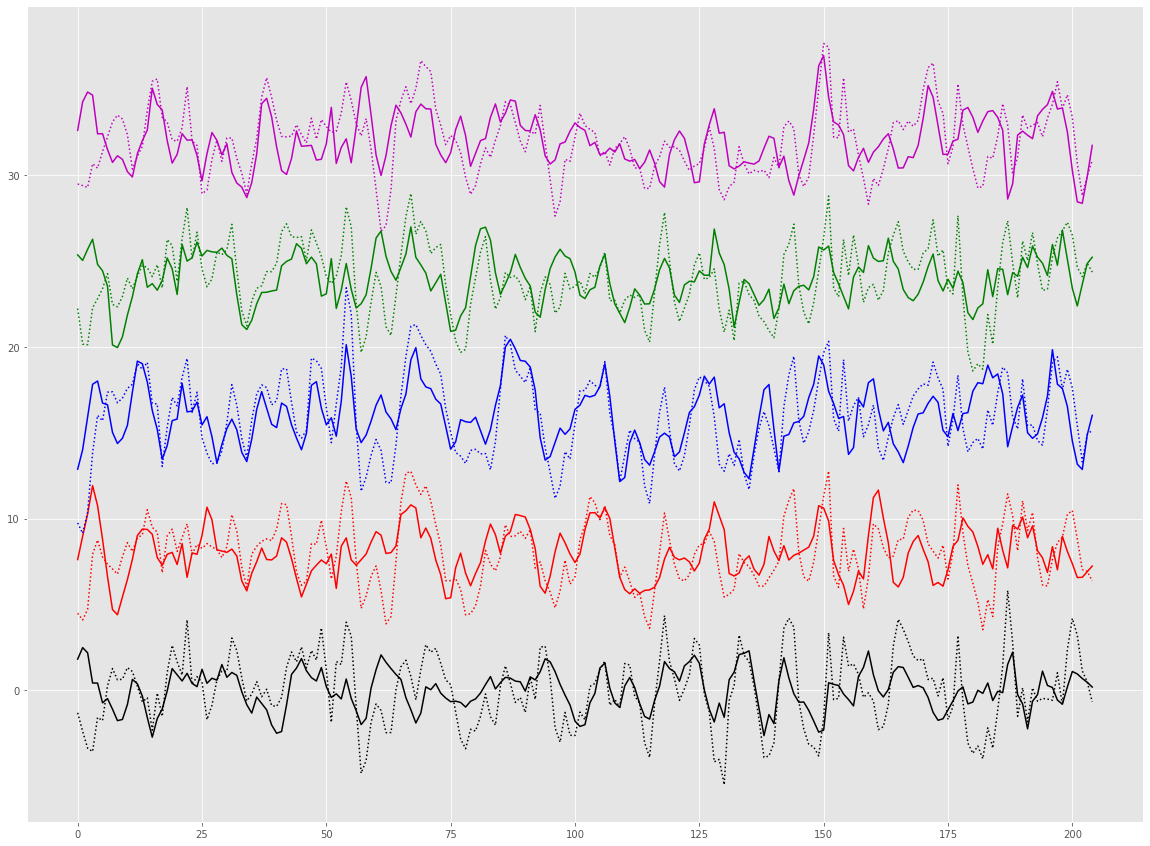

In [9]:
subject = 1
fmri = data.TimeSeries(subject=subject)
fmri_df = fmri.data_df.T
fmri_filtered = fmri_df - fmri_df.mean(axis = 0)
fmri_filtered = fmri_filtered.T
fmri.data_df = fmri_filtered
fmri.data_mat = fmri_filtered.to_numpy()

color = ['k', 'r', 'b', 'g', 'm']
plt.figure(figsize=(20,15))
for i in range(5):
    plt.plot(fmri.data_df[i]+8*i, color = color[i])
    plt.plot(data.TimeSeries(subject=subject).data_df[i]+8*i, ":", color = color[i])
plt.show()

# Computed filtered delayedPearson matrices

In [2]:
CTR_start = 1
PD_CN_start = 16
PD_MCI_start = 88

#range_of_subjects = [CTR_start + i for i in range(5)] + [PD_CN_start + i for i in range(5)] + [PD_MCI_start + i for i in range(5)]
#to_remove = [CTR_start + i for i in range(5)] + [PD_CN_start + i for i in range(5)] + [PD_MCI_start + i for i in range(5)]
range_of_subjects = [i for i in range(1, 107)]
#for element in to_remove:
#    range_of_subjects.remove(element)
range_of_delays = range(1, 4)

for delay in range_of_delays:
    for subject in tqdm(range_of_subjects):
        fmri = data.TimeSeries(subject=subject)
        fmri_df = fmri.data_df.T
        fmri_filtered = fmri_df - fmri_df.mean(axis = 0)
        fmri_filtered = fmri_filtered.T
        fmri.data_df = fmri_filtered
        fmri.data_mat = fmri_filtered.to_numpy()
        corMat = data.delayed_Pearson_correlation(fmri, delay = delay)
        corMat_df = pd.DataFrame(corMat)
        path = os.getcwd()+"\\data\\Matrices_Naomi\\filtered_delayedPearson\\FDP_delay"+str(delay)
        corMat_df.to_csv(path+"\\FDP_delay"+str(delay)+"_Subject"+str(subject)+".csv", header=None, index=None)

100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [06:27<00:00,  3.65s/it]


C:\Users\naomi\AppData\Local\Miniconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  del sys.path[0]


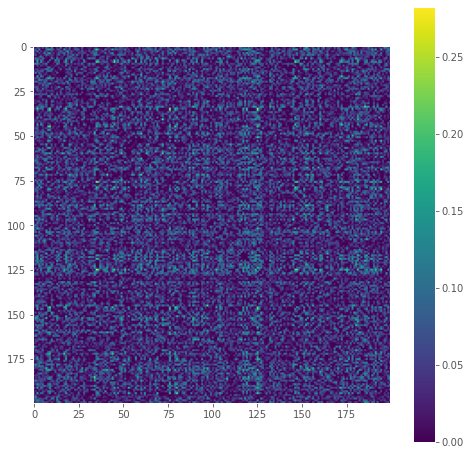

In [12]:
subject = 3
method="filtered_delayedPearson"
submethod="FDP_delay"+str(delay) 
symmetrization="antisymmetric_part"

dist_mat_object = data.DistanceMatrix(subject=subject, method=method, submethod=submethod)
dist_mat = dist_mat_object.dist_mat
dist_mat = data.symmetrize_matrix(matrix=dist_mat, symmetrization=symmetrization)

plt.figure(figsize=(8,8))
plt.grid(False)
plt.imshow(dist_mat)
plt.colorbar()

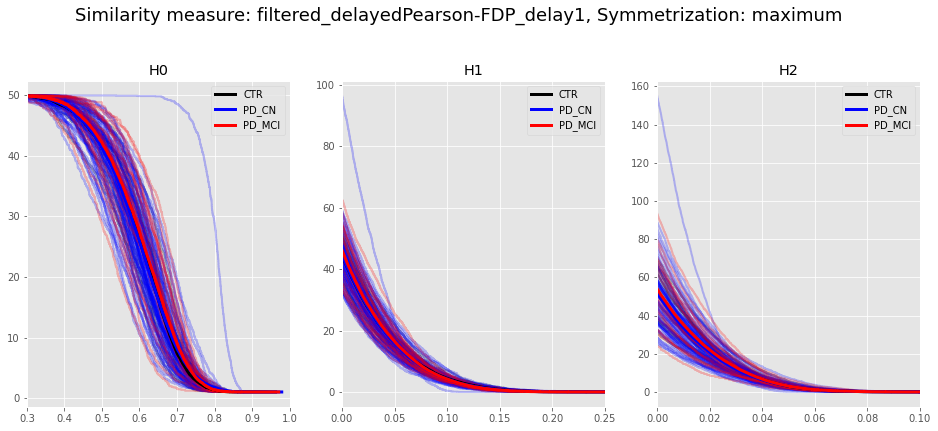

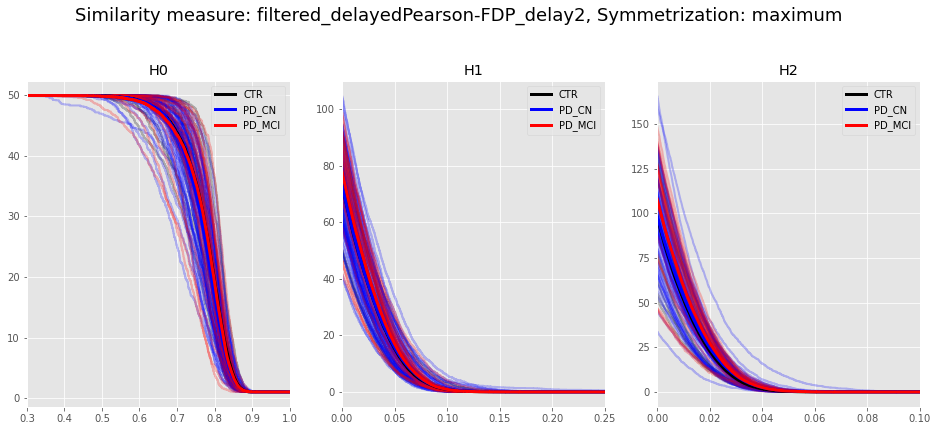

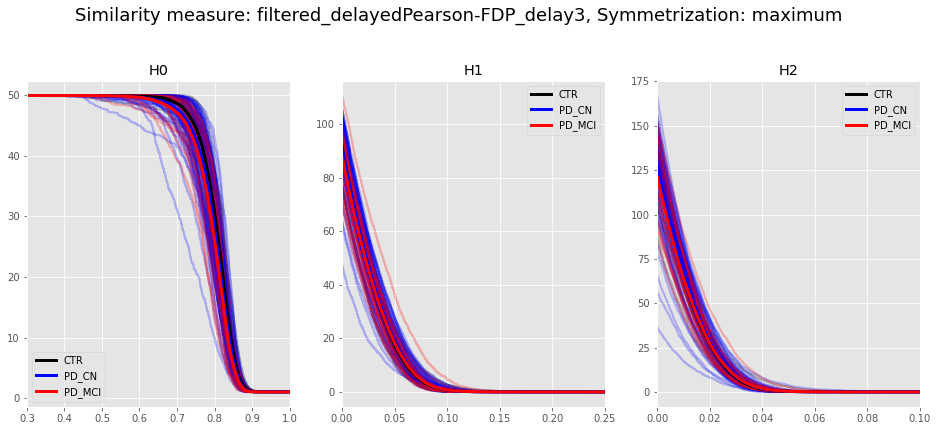

In [18]:
CTR_start = 1
PD_CN_start = 16
PD_MCI_start = 88

#range_of_subjects = [CTR_start + i for i in range(5)] + [PD_CN_start + i for i in range(5)] + [PD_MCI_start + i for i in range(5)]
#to_remove = [CTR_start + i for i in range(5)] + [PD_CN_start + i for i in range(5)] + [PD_MCI_start + i for i in range(5)]
range_of_subjects = [i for i in range(1, 107)]
#for element in to_remove:
#    range_of_subjects.remove(element)
range_of_delays = range(1, 4)

method = "filtered_delayedPearson"
symmetrization = "maximum"

for delay in range_of_delays:
    submethod = "FDP_delay"+str(delay)
    fig, ax = plotting.compute_and_plot_sr(range_of_subjects=range_of_subjects, 
                                           method=method, 
                                           submethod=submethod,
                                           symmetrization=symmetrization,
                                           neg_vals_method="abs",
                                           cor_to_dist_func="linear",
                                           max_hom=2,
                                           number_instances=20,
                                           sample_size=50,
                                           probabilities=200)
    ax[0].set_xlim(0.3, 1)
    ax[1].set_xlim(0, 0.25)
    ax[2].set_xlim(0, 0.1)

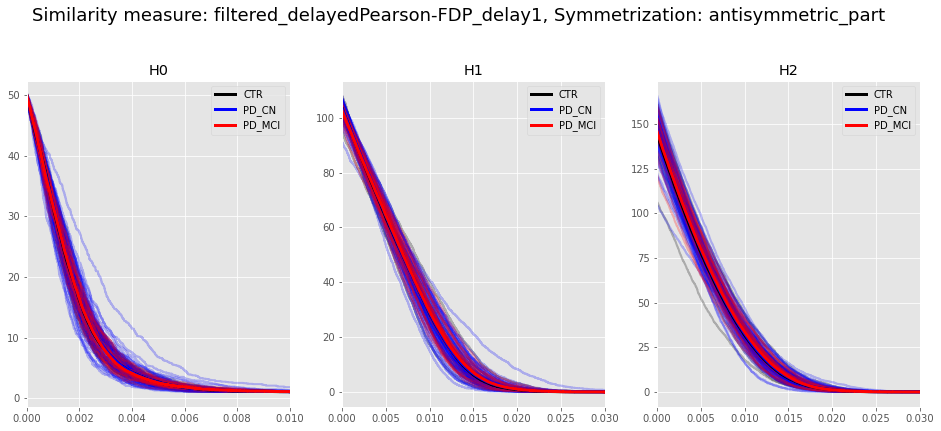

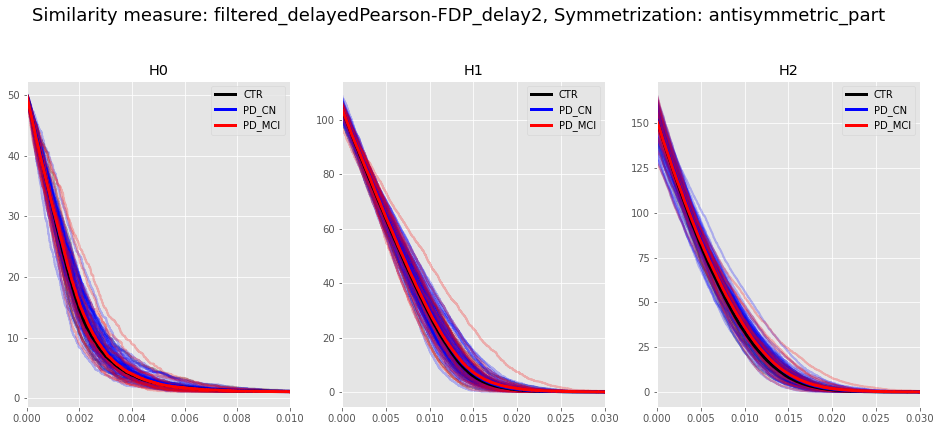

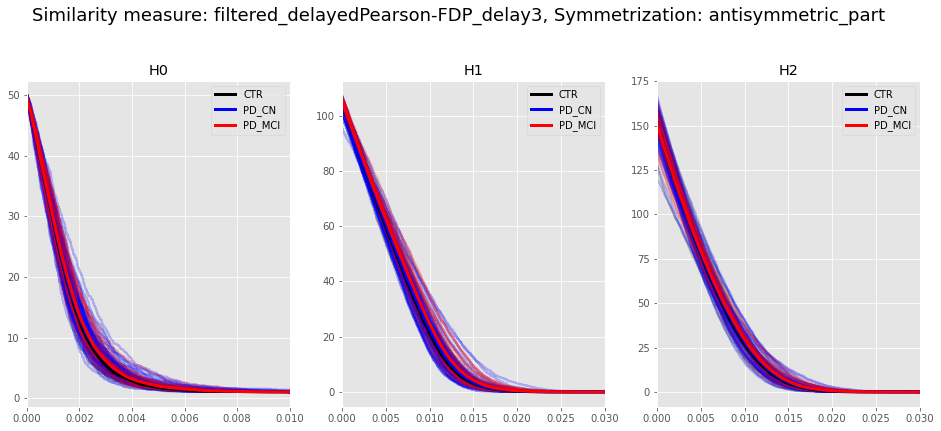

In [19]:
CTR_start = 1
PD_CN_start = 16
PD_MCI_start = 88

#range_of_subjects = [CTR_start + i for i in range(5)] + [PD_CN_start + i for i in range(5)] + [PD_MCI_start + i for i in range(5)]
#to_remove = [CTR_start + i for i in range(5)] + [PD_CN_start + i for i in range(5)] + [PD_MCI_start + i for i in range(5)]
range_of_subjects = [i for i in range(1, 107)]
#for element in to_remove:
#    range_of_subjects.remove(element)
range_of_delays = range(1, 4)

method = "filtered_delayedPearson"
symmetrization = "antisymmetric_part"

for delay in range_of_delays:
    submethod = "FDP_delay"+str(delay)
    fig, ax = plotting.compute_and_plot_sr(range_of_subjects=range_of_subjects, 
                                           method=method, 
                                           submethod=submethod,
                                           symmetrization=symmetrization,
                                           neg_vals_method="abs",
                                           cor_to_dist_func="linear",
                                           max_hom=2,
                                           number_instances=20,
                                           sample_size=50,
                                           probabilities=200)
    ax[0].set_xlim(0, 0.01)
    ax[1].set_xlim(0, 0.03)
    ax[2].set_xlim(0, 0.03)

In [3]:
CTR_start = 1
PD_CN_start = 16
PD_MCI_start = 88

#range_of_subjects = [CTR_start + i for i in range(5)] + [PD_CN_start + i for i in range(5)] + [PD_MCI_start + i for i in range(5)]
#to_remove = [CTR_start + i for i in range(5)] + [PD_CN_start + i for i in range(5)] + [PD_MCI_start + i for i in range(5)]
range_of_subjects = [i for i in range(1, 107)]
#for element in to_remove:
#    range_of_subjects.remove(element)

delay = 0
for subject in tqdm(range_of_subjects):
    fmri = data.TimeSeries(subject=subject)
    fmri_df = fmri.data_df.T
    fmri_filtered = fmri_df - fmri_df.mean(axis = 0)
    fmri_filtered = fmri_filtered.T
    fmri.data_df = fmri_filtered
    fmri.data_mat = fmri_filtered.to_numpy()
    corMat = data.delayed_Pearson_correlation(fmri, delay = delay)
    corMat_df = pd.DataFrame(corMat)
    path = os.getcwd()+"\\data\\Matrices_Naomi\\filtered_delayedPearson\\FDP_delay"+str(delay)
    corMat_df.to_csv(path+"\\FDP_delay"+str(delay)+"_Subject"+str(subject)+".csv", header=None, index=None)

100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [06:22<00:00,  3.61s/it]


100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [00:35<00:00,  3.00it/s]


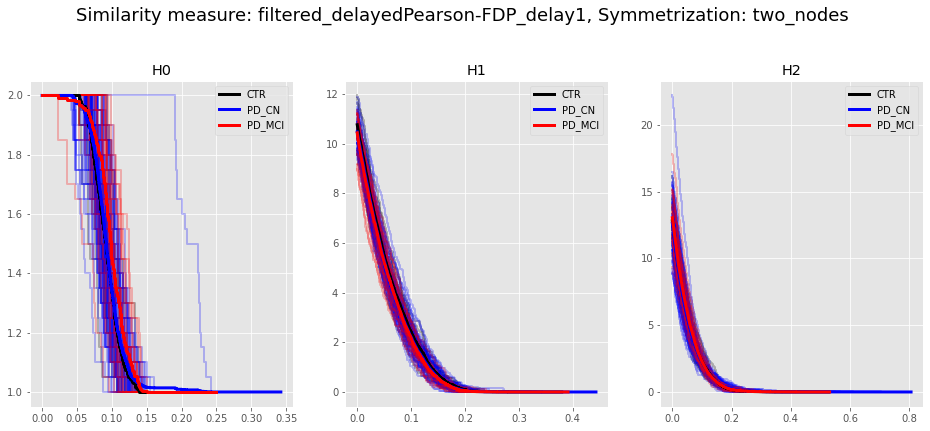

In [30]:
CTR_start = 1
PD_CN_start = 16
PD_MCI_start = 88

#range_of_subjects = [CTR_start + i for i in range(5)] + [PD_CN_start + i for i in range(5)] + [PD_MCI_start + i for i in range(5)]
#to_remove = [CTR_start + i for i in range(5)] + [PD_CN_start + i for i in range(5)] + [PD_MCI_start + i for i in range(5)]
range_of_subjects = [i for i in range(1, 107)]
#for element in to_remove:
#    range_of_subjects.remove(element)

delay = 1
method = "filtered_delayedPearson"
submethod = "FDP_delay"+str(delay)
symmetrization = "two_nodes"
neg_vals_method = "clip_zero"
cor_to_dist_func = "log"
normalize = True
max_hom = 2
number_instances = 20
sample_size = 50
probabilities = 200
fig, ax, all_hsrs = plotting.compute_and_plot_sr(range_of_subjects=range_of_subjects, 
                                       method=method, 
                                       submethod=submethod,
                                       symmetrization=symmetrization,
                                       neg_vals_method=neg_vals_method,
                                       cor_to_dist_func=cor_to_dist_func,
                                       normalize=normalize,
                                       max_hom=max_hom,
                                       number_instances=number_instances,
                                       sample_size=sample_size,
                                       probabilities=probabilities)

C:\Users\naomi\AppData\Local\Miniconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


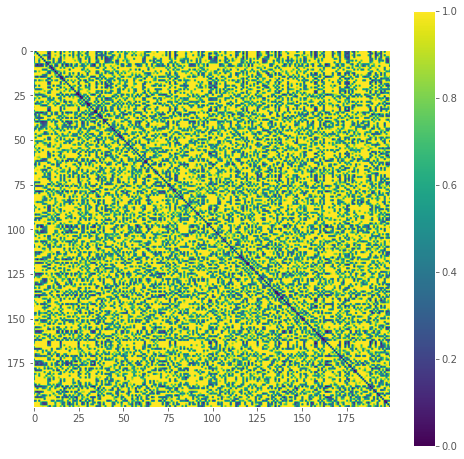

In [31]:
delay = 1
method = "filtered_delayedPearson"
submethod = "FDP_delay"+str(delay)
symmetrization = "maximum"
neg_vals_method = "clip_zero_inv"
cor_to_dist_func = "log"
normalize = True
max_hom = 2
number_instances = 20
sample_size = 50
probabilities = 200

subject = 1

dist_mat_object = data.DistanceMatrix(subject=subject, method=method, submethod=submethod, neg_vals_method=neg_vals_method, cor_to_dist_func=cor_to_dist_func)
dist_mat = dist_mat_object.dist_mat
dist_mat = data.symmetrize_matrix(matrix=dist_mat, symmetrization=symmetrization)

if normalize == True:
    dist_mat = data.normalize_matrix(dist_mat)
            
plt.figure(figsize=(8,8))
plt.grid(False)
plt.imshow(dist_mat)
plt.colorbar()
plt.show()

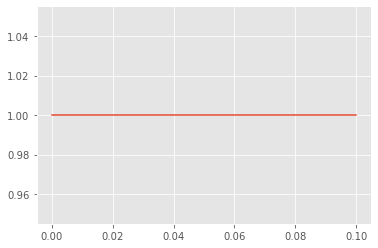

In [9]:
s = sr.get_sample(number_instances, sample_size, probabilities) 
d = sr.Distance(dist_mat)
bc = d.get_bc(maxdim = max_hom, sample=s)
hsr = sr.bc_to_sr(bc, degree = "H0")
hsr.plot()

In [26]:
neg_vals_method = "clip_zero"
cor_to_dist_func = "linear"
symmetrization = "symmetric_part"

dist_mat_object = data.DistanceMatrix(subject=subject, method=method, submethod=submethod, neg_vals_method=neg_vals_method, cor_to_dist_func=cor_to_dist_func)
dist_mat = dist_mat_object.dist_mat
dist_mat = data.symmetrize_matrix(matrix=dist_mat, symmetrization=symmetrization)
pd.DataFrame(dist_mat)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,1.000000,1.000000,0.940974,0.924401,1.000000,0.849269,1.000000,0.921494,0.957138,0.962672,...,1.000000,0.991346,1.000000,0.919056,0.741176,1.000000,0.825655,0.910550,0.953238,1.000000
1,1.000000,1.000000,0.706390,1.000000,0.920145,1.000000,0.702542,0.727469,1.000000,1.000000,...,0.736054,1.000000,0.918295,1.000000,1.000000,1.000000,0.971705,1.000000,0.962520,0.874654
2,0.940974,0.706390,1.000000,0.997297,1.000000,0.841019,0.738143,1.000000,0.995661,0.991740,...,1.000000,0.905428,1.000000,1.000000,0.809100,1.000000,0.710899,1.000000,1.000000,0.964102
3,0.924401,1.000000,0.997297,1.000000,1.000000,1.000000,1.000000,0.975784,0.836260,0.875387,...,1.000000,1.000000,1.000000,0.805391,0.928818,0.747065,1.000000,0.884541,0.741950,0.887712
4,1.000000,0.920145,1.000000,1.000000,1.000000,1.000000,0.913579,0.720608,1.000000,1.000000,...,0.664011,1.000000,0.613056,1.000000,1.000000,0.846180,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.000000,1.000000,1.000000,0.747065,0.846180,1.000000,1.000000,1.000000,0.990713,0.978171,...,1.000000,1.000000,0.855108,0.908908,1.000000,1.000000,1.000000,0.988263,0.756059,0.991341
196,0.825655,0.971705,0.710899,1.000000,1.000000,0.749113,0.945538,1.000000,1.000000,0.934998,...,1.000000,0.717020,1.000000,1.000000,0.571703,1.000000,1.000000,1.000000,0.986415,1.000000
197,0.910550,1.000000,1.000000,0.884541,1.000000,1.000000,1.000000,1.000000,0.668425,0.653209,...,1.000000,0.899837,1.000000,0.750807,0.914909,0.988263,1.000000,1.000000,0.788390,0.882323
198,0.953238,0.962520,1.000000,0.741950,1.000000,1.000000,1.000000,1.000000,0.938676,0.757460,...,1.000000,0.988010,1.000000,0.788162,0.942121,0.756059,0.986415,0.788390,1.000000,0.972613


In [13]:
features_dict = {}
for subject in range_of_subjects:
    features_sj = []
    
    for hom in range(3):
        if subject < PD_CN_start:
            color = 'k'
        elif (subject >= PD_CN_start and subject < PD_MCI_start):
            color = 'b'
        else: 
            color = 'r'

        features_sj.append(all_hsrs[subject][hom].integrate(0,1))
        features_sj.append(all_hsrs2[subject][hom].integrate(0,1))
    
    features_dict[subject] = features_sj
    
features = pd.DataFrame.from_dict(features_dict).transpose()
features

,0,1,2,3,4,5
1,28.689517,31.747653,1.429394,30.105318,0.284227,22.120431
2,27.504429,32.359620,1.715920,23.396127,0.381054,19.903283
3,27.126719,30.687365,1.411613,37.968623,0.345637,19.453046
4,29.732950,34.632817,1.887539,19.132747,0.487125,12.422472
5,28.799246,32.938014,1.929156,21.585370,0.541793,15.597726
...,...,...,...,...,...,...
102,32.223836,35.784154,2.134561,15.474704,0.780239,10.830155
103,29.295571,33.798098,1.492358,26.828584,0.370549,19.188244
104,29.288202,33.891430,1.414871,26.206971,0.337895,17.403082
105,29.408441,31.299385,1.451834,33.041339,0.361851,18.023741


In [27]:
scaler = MinMaxScaler()
scaler.fit(features)
scaled = scaler.fit_transform(features)
scaled_features = pd.DataFrame(scaled, columns = features.columns)
nr_of_features = len(scaled_features.columns)
scaled_features

,0,1,2,3,4,5
0,0.269312,0.276083,0.256841,0.538114,0.129472,0.548269
1,0.188437,0.333805,0.454410,0.378264,0.215373,0.477457
2,0.162661,0.176074,0.244580,0.725462,0.183952,0.463078
3,0.340520,0.548219,0.572748,0.276686,0.309473,0.238535
4,0.276801,0.388361,0.601444,0.335121,0.357973,0.339947
...,...,...,...,...,...,...
101,0.510507,0.656816,0.743078,0.189531,0.569511,0.187680
102,0.310672,0.469486,0.300257,0.460044,0.206052,0.454621
103,0.310169,0.478289,0.246827,0.445234,0.177083,0.397606
104,0.318374,0.233801,0.272314,0.608067,0.198336,0.417429


In [15]:
pca = PCA(n_components = 2)
pcs = pca.fit_transform(scaled_features)

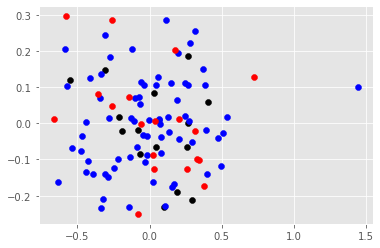

In [18]:
plt.figure()
plt.scatter(pcs[:PD_CN_start-1,0], pcs[:PD_CN_start-1,1], color = "k")
plt.scatter(pcs[PD_CN_start-1:PD_MCI_start-1,0], pcs[PD_CN_start-1:PD_MCI_start-1,1], color = "b")
plt.scatter(pcs[PD_MCI_start-1:,0], pcs[PD_MCI_start-1:,1], color = "r")